In [1]:
from freshDecoder import *
from encoder import *
from fresh_data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt


[nltk_data] Downloading package punkt to /home/riley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:


def validate(val_loader, encoder, decoder, criterion, maxSeqLen,
             vocab, use_gpu = True, calculate_bleu = True):

    
    #Evaluation Mode
    decoder.eval()
    encoder.eval()

    
    references = list()
    hypotheses = list() 
    
    if use_gpu:
        device = torch.device("cuda:0")
        
        
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        bleu1_avg = 0
        bleu4_avg = 0
        
        for i, (inputs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            if use_gpu:
                inputs = inputs.to(device)
                caps = caps.to(device)

                        
            enc_out = encoder(inputs)
            actual_lengths = allcaps
            
            
            
            temperature = 1
            test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)

            test_pred_sample = test_pred[0].cpu().numpy()          

            

            
            #Build a list of the predicted sentences
            # Convert word_ids to words
            sampled_caption = []

            for word_id in test_pred_sample:
                word = vocab.idx2word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            hypotheses.append(sampled_caption)                
            #if i % 750 ==0:
                #print ('generated sentence: ',sentence)            
                #print(type(sampled_caption))        
                #print(sampled_caption)        
                #print('len(generated_sentence): ',len(sampled_caption))

                
            #targets = pack_padded_sequence(labels, lengths, batch_first=True)[0]
        
            outputs = decoder(caps, enc_out, actual_lengths)
#             if i % 1000 == 0:
#                 print('VAL: outputs shape: ', outputs.size())
            new_outputs = torch.zeros(inputs.shape[0], maxSeqLen, vocab.idx)
            new_outputs[:inputs.shape[0],:maxSeqLen, 0] = torch.ones((inputs.shape[0], maxSeqLen))
#             for dim in range(maxSeqLen):
#                 for b in range(inputs.shape[0]):
#                     new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            
            #del inputs

            
            loss = criterion(new_outputs, Variable(caps.long()))
            loss_avg += loss
            count+=1
            
            #del outputs            
            
            #print('VAL: loss: ', loss)

            
            
            caps_array = caps.cpu().numpy()  
            # Convert word_ids to words
            reference_caption = []
            sampled_caption = []
            
            for word_id in caps_array[0]:
                word = vocab.idx2word[word_id]
                reference_caption.append(word)
                if word == '<end>':
                    break
            ref_sentence = ' '.join(reference_caption)
            #if i % 500 == 0:
                #print('ref_sentence: ', ref_sentence)
                #print('len(ref_sentence): ',len(reference_caption))
            references.append(reference_caption)   
        

        
        
            #print('len(references)', len(references))
            #print('len(hypotheses)', len(hypotheses))
            #print('references: ', references)
            #print('hypotheses: ', hypotheses)
        

            # Calculate BLEU-4 scores
            if calculate_bleu:
                bleu4 = corpus_bleu(references, hypotheses)                
                bleu1 = corpus_bleu(references, hypotheses,weights=(1.0, 0, 0, 0))
                #print('bleu4: ', bleu4)        
                #print('bleu1: ', bleu1)  
                bleu4_avg+=bleu4
                bleu1_avg+=bleu1
            
            del caps
            del outputs            
            
            
            #if i % 100 == 0:
            #    break
                
                
        if calculate_bleu:
            loss_avg  = loss_avg/count
            bleu4_avg = bleu4_avg/count
            bleu1_avg = bleu1_avg/count 
            #print('VAL: loss_avg: ', loss_avg)
            #print('VAL: bleu4_avg: ', bleu4_avg)
            #print('VAL: bleu1_avg: ', bleu1_avg)
        
        
        
        
            
    return loss_avg

In [3]:
def trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    parameters = list(encoder.fc.parameters())
    parameters.extend(list(decoder.parameters()))
    optimizer = optim.Adam(parameters, lr=1e-6)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")
#         encoder = torch.nn.DataParallel(encoder)
#         decoder = torch.nn.DataParallel(decoder)
        
        encoder.to(device)
        decoder.to(device)
        
        
    
    val_loss_set = []
    val_acc_set = []
    val_iou_set = []
    
    
    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 10
    earlyStopDelta = 5
    for epoch in range(epochs):
        ts = time.time()

                            
        for iter, (inputs, labels, lengths) in tqdm(enumerate(train_loader)):

            optimizer.zero_grad()
            
            
            encoder.train()
            decoder.train()
            
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            
                
            enc_out = encoder(inputs)
            
            temperature = 1
            
            
            
            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            #targets = pack_padded_sequence(labels, lengths, batch_first=True)
            #targets = pack_padded_sequence(labels, actual_lengths, batch_first=True, enforce_sorted=False)
            #targets = torch.zeros()
            loss = criterion(outputs, labels.cuda())
            del labels
            del outputs

            loss.backward()
#             loss = loss#.item()
            optimizer.step()

            if iter % 200 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss))
#                 test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()
#                 for b in range(inputs.shape[0]):
#                     caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
#                     img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
#                     plt.imshow(img)
                    
#                     plt.show()
#                     print("Caption: " + caption)
                
        print("epoch{}, iter{}, loss: {}, epoch duration: {}".format(epoch, iter, loss, time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()

        for b in range(inputs.shape[0]):
            caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
            img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
            plt.imshow(img)
                    
            plt.show()
            print("Caption: " + caption)

        
        # calculate val loss each epoch
        #val_loss  = validate(val_loader, encoder, decoder, criterion,maxSeqLen,
        #                     vocab, use_gpu)
        #val_loss_set.append(val_loss)

        
#         print("epoch {}, time {}, train loss {}, val loss {}, val acc {}, val iou {}".format(epoch, time.time() - ts,
#                                                                                                loss, val_loss,
#                                                                                                val_acc,
#                                                                                                val_iou))        
        training_loss.append(loss)
        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
#             file.write("\n Validation Loss: " + str(val_loss_set[-1]))
#             file.write("\n Validation acc:  " + str(val_acc_set[-1]))
#             file.write("\n Validation iou:  " + str(val_iou_set[-1]) + "\n ")                                             
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(model, name)
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
        # If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
    with open(logname_summary, "a") as file:
            file.write("Summary!\n")
            file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss: " + str(val_loss_set))
            file.write("\n Validation acc:  " + str(val_acc_set))
            file.write("\n Validation iou:  " + str(val_iou_set) + "\n ")
            
        
    #return val_loss_set, val_acc_set, val_iou_set

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Loading results to logfile: ./logs/LSTM22.log
Loading Summary to : ./logs/LSTM_summary22.log


1it [00:00,  3.10it/s]

epoch0, iter0, loss: 9.169675827026367


201it [00:26,  6.83it/s]

epoch0, iter200, loss: 7.070495128631592


401it [00:53,  6.93it/s]

epoch0, iter400, loss: 3.5211830139160156


602it [01:19,  7.75it/s]

epoch0, iter600, loss: 2.5432217121124268


801it [01:45,  7.00it/s]

epoch0, iter800, loss: 2.999897003173828


1001it [02:12,  6.77it/s]

epoch0, iter1000, loss: 2.4985435009002686


1201it [02:39,  7.09it/s]

epoch0, iter1200, loss: 2.2224831581115723


1401it [03:05,  7.04it/s]

epoch0, iter1400, loss: 2.115361452102661


1601it [03:32,  6.57it/s]

epoch0, iter1600, loss: 2.1146912574768066


1801it [03:59,  6.97it/s]

epoch0, iter1800, loss: 2.0429065227508545


2001it [04:26,  6.80it/s]

epoch0, iter2000, loss: 2.0726332664489746


2202it [04:53,  6.99it/s]

epoch0, iter2200, loss: 2.4647364616394043


2401it [05:19,  6.78it/s]

epoch0, iter2400, loss: 1.6938059329986572


2601it [05:46,  6.86it/s]

epoch0, iter2600, loss: 1.8871318101882935


2801it [06:13,  7.12it/s]

epoch0, iter2800, loss: 1.5589581727981567


3001it [06:40,  6.84it/s]

epoch0, iter3000, loss: 1.6843576431274414


3201it [07:06,  7.67it/s]

epoch0, iter3200, loss: 1.3280960321426392


3402it [07:32,  7.44it/s]

epoch0, iter3400, loss: 1.3729193210601807


3601it [07:59,  7.01it/s]

epoch0, iter3600, loss: 1.2465366125106812


3801it [08:26,  6.63it/s]

epoch0, iter3800, loss: 1.4798651933670044


4001it [08:52,  6.70it/s]

epoch0, iter4000, loss: 1.2046895027160645


4201it [09:19,  6.60it/s]

epoch0, iter4200, loss: 1.3143550157546997


4401it [09:46,  6.66it/s]

epoch0, iter4400, loss: 1.2968122959136963


4601it [10:13,  6.67it/s]

epoch0, iter4600, loss: 1.1629005670547485


4801it [10:40,  6.65it/s]

epoch0, iter4800, loss: 1.247685432434082


5001it [11:07,  6.66it/s]

epoch0, iter5000, loss: 1.012995958328247


5201it [11:34,  6.59it/s]

epoch0, iter5200, loss: 1.38316011428833


5401it [12:01,  6.82it/s]

epoch0, iter5400, loss: 1.2924779653549194


5601it [12:28,  6.79it/s]

epoch0, iter5600, loss: 1.0498601198196411


5801it [12:55,  7.14it/s]

epoch0, iter5800, loss: 1.09761643409729


6001it [13:22,  6.78it/s]

epoch0, iter6000, loss: 1.1940597295761108


6201it [13:49,  6.90it/s]

epoch0, iter6200, loss: 1.0857046842575073


6401it [14:16,  7.03it/s]

epoch0, iter6400, loss: 1.1429492235183716


6601it [14:43,  7.15it/s]

epoch0, iter6600, loss: 1.077345609664917


6625it [14:46,  7.47it/s]


epoch0, iter6624, loss: 1.0369073152542114, epoch duration: 886.6263208389282


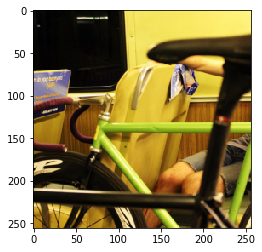

Caption: <start> a a man a on a a on a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


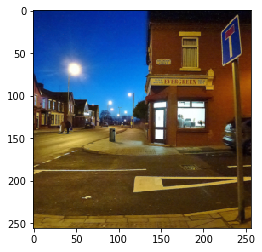

Caption: <start> a a man a on a a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


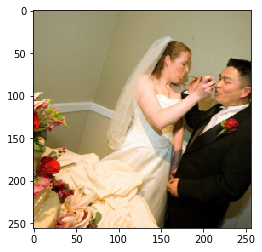

Caption: <start> a a man a on a a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


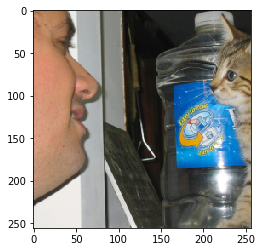

Caption: <start> a a man a on a a on a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


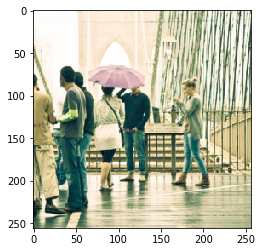

Caption: <start> a a man a on a a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


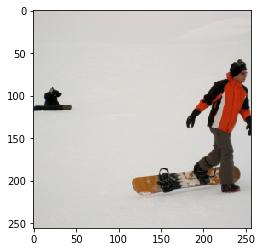

Caption: <start> a a man a on a a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


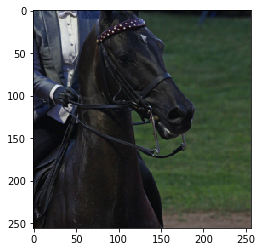

Caption: <start> a a man a on a a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


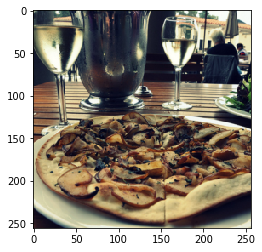

Caption: <start> a a man a on a a on a . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


1it [00:00,  3.22it/s]

epoch1, iter0, loss: 1.1260104179382324


201it [00:27,  7.23it/s]

epoch1, iter200, loss: 1.2379034757614136


401it [00:54,  6.64it/s]

epoch1, iter400, loss: 1.1958446502685547


601it [01:21,  7.20it/s]

epoch1, iter600, loss: 1.1225398778915405


801it [01:47,  6.82it/s]

epoch1, iter800, loss: 1.1607357263565063


1001it [02:14,  6.60it/s]

epoch1, iter1000, loss: 1.029852032661438


1201it [02:41,  6.51it/s]

epoch1, iter1200, loss: 1.0459638833999634


1401it [03:08,  6.83it/s]

epoch1, iter1400, loss: 1.0693416595458984


1601it [03:35,  6.54it/s]

epoch1, iter1600, loss: 1.1155266761779785


1801it [04:02,  6.46it/s]

epoch1, iter1800, loss: 1.0035724639892578


1986it [04:27,  7.57it/s]

In [ ]:
if __name__=='__main__':
    with open('TrainImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        trainIds = list(reader)[0]
        
    with open('TestImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        testIds = list(reader)[0]
    
    trainIds = [int(i) for i in trainIds]
    testIds = [int(i) for i in testIds]
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/images/train/"
    testRoot = "./data/images/test/"
    
    trainValJson = "./data/annotations/captions_train2014.json"
    testJson = "./data/annotations/captions_val2014.json"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 256
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 10
    shuffle = True
    num_workers = 5
    
    
    trainDl = get_loader(trainValRoot, trainValJson, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValJson, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testJson, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 1024
    maxSeqLen = 56
    hidden_dim = 1500
    depth = 1
    
    encoder = Encoder(encoded_feature_dim)
    # Turn off all gradients in encoder
    for param in encoder.parameters():
        param.requires_grad = False
    # Turn on gradient of final hidden layer for fine tuning
    for param in encoder.fc.parameters():
        param.requires_grad = True
    decoder = Decoder(encoded_feature_dim, hidden_dim, depth, vocab.idx, batch_size)
    
#     criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    
    epochs = 100
    trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        trainDl, valDl, testDl, "LSTM",
                        batch_size, maxSeqLen, vocab)

In [ ]:
%debug

In [ ]:
vocab.idx

In [ ]:
x = torch.Tensor([])